In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/leowyy/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer
import networkx as nx
import scipy.sparse as sp

In [3]:
from core.SimpleNet import SimpleNet
from core.GraphConvNet import GraphConvNet
from core.EmbeddingDataSet import EmbeddingDataSet
from core.GraphDataBlock import GraphDataBlock
from util.plot_graph_embedding import plot_graph_embedding
from util.evaluation_metrics import evaluate_viz_metrics, trustworthiness, neighborhood_preservation
from util.network_utils import get_net_projection
from util.graph_utils import get_shortest_path_matrix, neighbor_sampling

cuda not available
cuda not available


In [4]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [5]:
if torch.cuda.is_available():
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    print('cuda available')
    device = 'cuda'
else:
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    print('cuda not available')
    device = 'cpu'

cuda not available


In [91]:
dataset_name = 'citeseer_test'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)
dataset.summarise()

Data blocks of length:  [3312]
Time to create all data (s) = 0.0540
Name of dataset = citeseer_test
Input dimension = 3703
Number of training samples = 3312
Training labels = True


In [92]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['L'] = 2 # number of hidden layers

In [93]:
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)

Data blocks of length:  [3312]
Time to create all data (s) = 0.0517


In [94]:
# path_matrix = get_shortest_path_matrix(dataset.adj_matrix.toarray())
# print(path_matrix.shape)
# np.save('path_matrix.npy', path_matrix)

## End of boilerplate code

In [95]:
main_dir = os.path.join('results', dataset_name)
main_dir

'results/citeseer_test'

In [96]:
path_matrix = np.load(os.path.join(input_dir, dataset_name) + '/path_matrix.npy')

In [97]:
# Graph net
def load_net_from_root(root, net_parameters):
    net_parameters['H'] = 128 # number of hidden units
    net_1 = GraphConvNet(net_parameters)
    if torch.cuda.is_available(): net_1.cuda()
    filename = os.path.join(root, 'graph_net_360.pkl')
    checkpoint = torch.load(filename, map_location=device)
    net_1.load_state_dict(checkpoint['state_dict'])
    return net_1

In [98]:
def project_and_eval(net, dataset):
    from sklearn.metrics import silhouette_score
    y_pred = get_net_projection(net, dataset)
    res = evaluate_viz_metrics(y_pred, dataset)
    res['Feature trustworthiness'] = trustworthiness(dataset.inputs, y_pred, metric='cosine')
    res['Graph trustworthiness'] = neighborhood_preservation(y_pred, path_matrix)
    res['Silhouette score'] = silhouette_score(y_pred, dataset.labels)
    return res

In [99]:
from collections import defaultdict

res_summary = defaultdict(list)
for i in range(1, 12):
    root = os.path.join(main_dir, dataset_name) + '_' + str(i)
    net = load_net_from_root(root, net_parameters)
    res = project_and_eval(net, dataset)
    for k, v in res.items():
        res_summary[k].append(v)

Data blocks of length:  [3312]
Time to create all data (s) = 0.0901
One NN accuracy = 0.6627
Avg graph distance = 0.8704
Avg feature distance = 0.8559
Total distance = 1.7263
Data blocks of length:  [3312]
Time to create all data (s) = 0.0826
One NN accuracy = 0.6781
Avg graph distance = 0.4210
Avg feature distance = 0.8659
Total distance = 1.2869
Data blocks of length:  [3312]
Time to create all data (s) = 0.0849
One NN accuracy = 0.6956
Avg graph distance = 0.2412
Avg feature distance = 0.9283
Total distance = 1.1695
Data blocks of length:  [3312]
Time to create all data (s) = 0.0870
One NN accuracy = 0.6929
Avg graph distance = 0.1598
Avg feature distance = 1.0205
Total distance = 1.1803
Data blocks of length:  [3312]
Time to create all data (s) = 0.0817
One NN accuracy = 0.7050
Avg graph distance = 0.1139
Avg feature distance = 1.0086
Total distance = 1.1225
Data blocks of length:  [3312]
Time to create all data (s) = 0.0812
One NN accuracy = 0.6984
Avg graph distance = 0.0783
Avg 

In [100]:
test_range = np.linspace(0, 1, num=11)

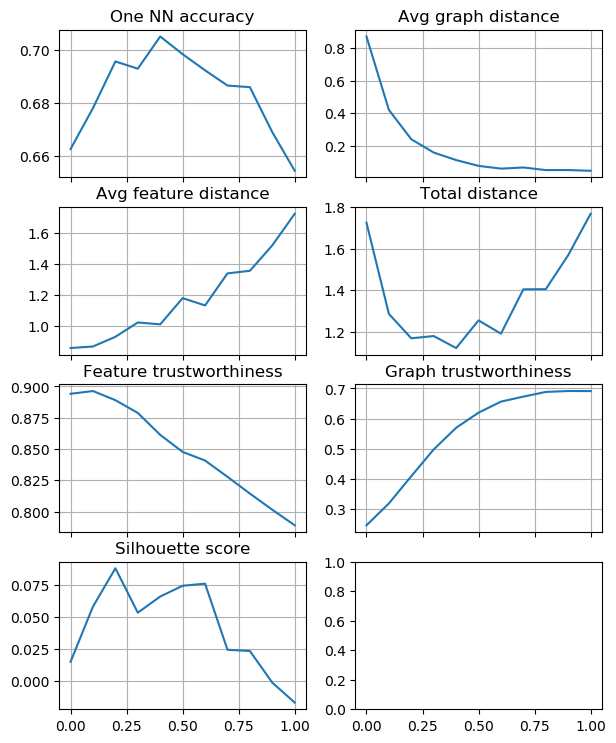

In [101]:
f, axarr = plt.subplots(4, 2, sharex='col', figsize=(7, 9), dpi=100)
for i, k in enumerate(res_summary.keys()):
    row, col = divmod(i, 2)
    axarr[row, col].plot(test_range, res_summary[k])
    axarr[row, col].set_title(k)
    axarr[row, col].grid()
    axarr[row, col].set_title(k)

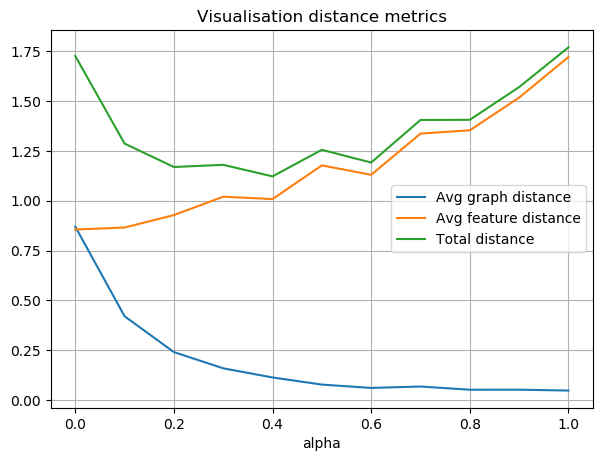

In [102]:
f, axarr = plt.subplots(1, sharex='col', figsize=(7, 5), dpi=100)
plt.plot(test_range, res_summary['Avg graph distance'], label='Avg graph distance')
plt.plot(test_range, res_summary['Avg feature distance'], label='Avg feature distance')
plt.plot(test_range, res_summary['Total distance'], label='Total distance')
plt.xlabel('alpha')
plt.title('Visualisation distance metrics')
plt.grid()
plt.legend()

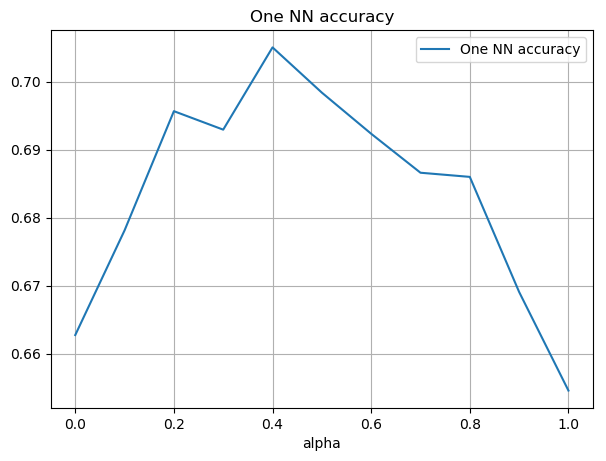

In [103]:
f, axarr = plt.subplots(1, sharex='col', figsize=(7, 5), dpi=100)
plt.plot(test_range, res_summary['One NN accuracy'], label='One NN accuracy')

plt.xlabel('alpha')
plt.title('One NN accuracy')
plt.grid()
plt.legend()

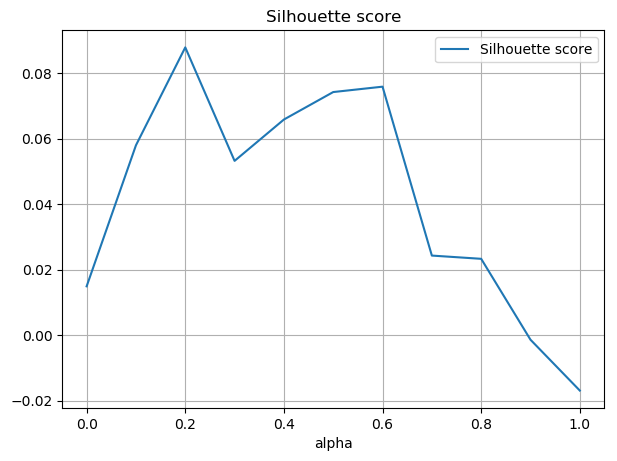

In [104]:
f, axarr = plt.subplots(1, sharex='col', figsize=(7, 5), dpi=100)
plt.plot(test_range, res_summary['Silhouette score'], label='Silhouette score')

plt.xlabel('alpha')
plt.title('Silhouette score')
plt.grid()
plt.legend()

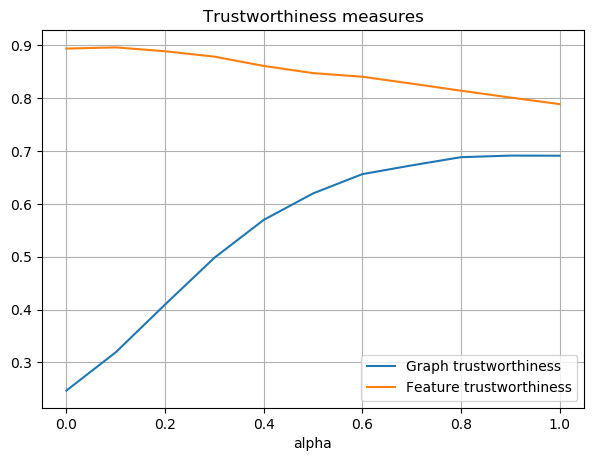

In [105]:
f, axarr = plt.subplots(1, sharex='col', figsize=(7, 5), dpi=100)
plt.plot(test_range, res_summary['Graph trustworthiness'], label='Graph trustworthiness')
plt.plot(test_range, res_summary['Feature trustworthiness'], label='Feature trustworthiness')

plt.xlabel('alpha')
plt.title('Trustworthiness measures')
plt.grid()
plt.legend()

In [113]:
root = os.path.join(main_dir, dataset_name) + '_' + str(5)
net = load_net_from_root(root, net_parameters)
y_pred = get_net_projection(net, dataset)
plot_graph_embedding(y_pred, dataset.labels, dataset.adj_matrix, line_alpha=0.1)

Data blocks of length:  [3312]
Time to create all data (s) = 0.0898


In [107]:
def get_net_embeddings(net, dataset, net_type, H=50):
    # Use the model object to select the desired layer
    if net_type == 'graph':
        layer = net._modules['gnn_cells'][0]
    elif net_type == 'simple':
        layer = net._modules['relu']

    # Get the total number of data points
    n = len(dataset.labels)

    # Define a function that will copy the output of a layer
    my_embedding = torch.zeros([n, H])

    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    # Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)

    # Perform projection to capture embeddings
    get_net_projection(net, dataset)

    return my_embedding

In [108]:
emb = get_net_embeddings(net, dataset, "graph", H=128)

Data blocks of length:  [3312]
Time to create all data (s) = 0.0560


In [109]:
emb.shape

torch.Size([3312, 128])

In [110]:
from sklearn.manifold import TSNE
embedder = TSNE(n_components=2, perplexity=30, verbose=1)
y_pred_tsne = embedder.fit_transform(emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3312 samples in 0.011s...
[t-SNE] Computed neighbors for 3312 samples in 0.987s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3312
[t-SNE] Computed conditional probabilities for sample 2000 / 3312
[t-SNE] Computed conditional probabilities for sample 3000 / 3312
[t-SNE] Computed conditional probabilities for sample 3312 / 3312
[t-SNE] Mean sigma: 2.337936
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.173058
[t-SNE] KL divergence after 1000 iterations: 0.923889


In [111]:
res = evaluate_viz_metrics(y_pred_tsne, dataset)
res['Feature trustworthiness'] = trustworthiness(dataset.inputs, y_pred_tsne, metric='cosine')
res['Graph trustworthiness'] = neighborhood_preservation(y_pred_tsne, path_matrix)
res['Silhouette score'] = silhouette_score(y_pred_tsne, dataset.labels)
for k, v in res.items():
    print("{} = {:.4f}".format(k,v))

One NN accuracy = 0.6503
Avg graph distance = 0.2668
Avg feature distance = 0.9609
Total distance = 1.2278
One NN accuracy = 0.6503
Avg graph distance = 0.2668
Avg feature distance = 0.9609
Total distance = 1.2278
Feature trustworthiness = 0.8221
Graph trustworthiness = 0.2217
Silhouette score = 0.0877


In [112]:
plot_graph_embedding(y_pred_tsne, dataset.labels, dataset.adj_matrix, line_alpha=0.1)